In [1]:
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go

from collections import defaultdict
from pathlib import Path
import pandas as pd
import numpy as np
from typing import *

import statsmodels
import statsmodels.api as sm
from statsmodels.othermod.betareg import BetaModel
import scipy.stats as stats
from scipy.stats import boxcox
from scipy.special import inv_boxcox

import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.feature_selection import RFECV
from sklearn.model_selection import KFold

from sklearn.model_selection import train_test_split
from sklearn.metrics import *

pio.renderers.default = "iframe"

In [2]:
base_path = "/data/saturation/n_craters_stop_condition_20230918"

ivs = [
    "slope",
    "effective_radius_multiplier",
    "r_stat_multiplier",
    "min_rim_percentage",
    "z",
    "za",
    "n_craters_in_study_region",
    "areal_density",
    "areal_density_overlap_2",
    "areal_density_overlap_3",
    "center_to_center_nearest_neighbor_distance_mean",
    "center_to_center_nearest_neighbor_distance_stdev",
    "center_to_center_nearest_neighbor_distance_min",
    "center_to_center_nearest_neighbor_distance_max",
    "radius_mean",
    "radius_stdev",
]

measured_ivs = [
    "slope",
    "z",
    "za",
    "n_craters_in_study_region",
    "areal_density",
    "areal_density_overlap_2",
    "areal_density_overlap_3",
    "center_to_center_nearest_neighbor_distance_mean",
    "center_to_center_nearest_neighbor_distance_stdev",
    "center_to_center_nearest_neighbor_distance_min",
    "center_to_center_nearest_neighbor_distance_max",
    "radius_mean",
    "radius_stdev",
]

In [3]:
def fix_up_df(df: pd.DataFrame):
    df["z"] = df.z.fillna(0)
    df["za"] = df.za.fillna(0)
    df["log_n_craters_added_in_study_region"] = np.log(df.n_craters_added_in_study_region)
    for x in ivs:
        df[f"log_{x}"] = np.log(1 + df[x])
    return df

In [4]:
n_simulations = 1000
sample_size = 100

train_df = pd.read_parquet(f"{base_path}/train_{n_simulations}_{sample_size}.parquet")
train_df = fix_up_df(train_df)

test_df = pd.read_parquet(f"{base_path}/test_{n_simulations}_{sample_size}.parquet")
test_df = fix_up_df(test_df)

metric = "post_saturation_n_craters_in_study_region_percentile"

/home/mason/code/saturation/venv_311/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning:

invalid value encountered in log

/home/mason/code/saturation/venv_311/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning:

invalid value encountered in log

/home/mason/code/saturation/venv_311/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning:

invalid value encountered in log

/home/mason/code/saturation/venv_311/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning:

invalid value encountered in log



### Linear regression models

In [5]:
def fit_and_report_statsmodels_glm_model(family: sm.families.Family,
                                         X_train,
                                         y_train,
                                         X_test,
                                         y_test,
                                         model_name):
    model = sm.GLM(y_train, X_train, family=family).fit()
    print(model.summary())

    y_pred = model.predict(X_train)
    rmse = mean_squared_error(y_pred, y_train, squared=False)
    mape = mean_absolute_percentage_error(y_pred, y_train)
    mae = mean_absolute_error(y_pred, y_train)
    print(f"***** {model_name} *****")
    print(f"Train RMSE: {rmse:.4f}, Train MAE: {mae:.4f}, Train MAPE: {mape:.4f}")

    residuals = y_train - y_pred
    plt.hist(residuals, bins=50)
    plt.show()

    ks_norm_p = stats.kstest(residuals, cdf=stats.norm.cdf).pvalue
    ad_result = stats.anderson(residuals, dist="norm")
    print(f"KS test p-value on training residuals: {ks_norm_p:.3f}")
    print(f"AD test on training residuals: {ad_result.statistic:.3f}, critical values: {ad_result.critical_values}, significance levels: {ad_result.significance_level}")

    print(f"*** Test set")
    y_pred = model.predict(X_test)
    rmse = mean_squared_error(y_pred, y_test, squared=False)
    mape = mean_absolute_percentage_error(y_pred, y_test)
    mae = mean_absolute_error(y_pred, y_test)
    print(f"Test RMSE: {rmse:.4f}, Test MAE: {mae:.4f}, Test MAPE: {mape:.4f}")

    y_pred_mean_model = [y_train.mean()] * len(y_test)
    rmse = mean_squared_error(y_pred_mean_model, y_test, squared=False)
    mape = mean_absolute_percentage_error(y_pred_mean_model, y_test)
    mae = mean_absolute_error(y_pred_mean_model, y_test)
    print(f"Mean model: RMSE: {rmse:.4f}, MAE: {mae:.4f}, MAPE: {mape:.4f}")
    
    return model

In [6]:
def fit_and_report_statsmodels_model(model_creator: Callable[[pd.DataFrame, pd.DataFrame], Any],
                                     X_train,
                                     y_train,
                                     X_test,
                                     y_test,
                                     model_name,
                                     transform=lambda x: x,
                                     inverse_transform=lambda x: x):
    y_train_transformed = transform(y_train)
    
    model = model_creator(y_train_transformed, X_train).fit()
    print(model.summary())

    y_pred = inverse_transform(model.predict(X_train))
    rmse = mean_squared_error(y_pred, y_train, squared=False)
    mape = mean_absolute_percentage_error(y_pred, y_train)
    mae = mean_absolute_error(y_pred, y_train)
    print(f"***** {model_name} *****")
    print(f"Train RMSE: {rmse:.4f}, MAE: {mae:.4f}, MAPE: {mape:.4f}")

    residuals = y_train - y_pred
    plt.hist(residuals, bins=50)
    plt.show()

    ks_norm_p = stats.kstest(residuals, cdf=stats.norm.cdf).pvalue
    ad_result = stats.anderson(residuals, dist="norm")
    print(f"KS test p-value on training residuals: {ks_norm_p:.3f}")
    print(f"AD test on training residuals: {ad_result.statistic:.3f}, critical values: {ad_result.critical_values}, significance levels: {ad_result.significance_level}")

    print(f"*** Test set")
    y_pred = inverse_transform(model.predict(X_test))
    rmse = mean_squared_error(y_pred, y_test, squared=False)
    mape = mean_absolute_percentage_error(y_pred, y_test)
    mae = mean_absolute_error(y_pred, y_test)
    print(f"Test RMSE: {rmse:.4f}, MAE: {mae:.4f}, MAPE: {mape:.4f}")

    y_pred_mean_model = [y_train.mean()] * len(y_test)
    rmse = mean_squared_error(y_pred_mean_model, y_test, squared=False)
    mape = mean_absolute_percentage_error(y_pred_mean_model, y_test)
    mae = mean_absolute_error(y_pred_mean_model, y_test)
    print(f"Mean model: RMSE: {rmse:.4f}, MAE: {mae:.4f}, MAPE: {mape:.4f}")
    
    return model

### Linear Regression Models

                                             OLS Regression Results                                             
Dep. Variable:     post_saturation_n_craters_in_study_region_percentile   R-squared:                       0.486
Model:                                                              OLS   Adj. R-squared:                  0.486
Method:                                                   Least Squares   F-statistic:                     4733.
Date:                                                  Sat, 23 Sep 2023   Prob (F-statistic):               0.00
Time:                                                          12:55:32   Log-Likelihood:                 2609.1
No. Observations:                                                 80000   AIC:                            -5184.
Df Residuals:                                                     79983   BIC:                            -5026.
Df Model:                                                            16                         

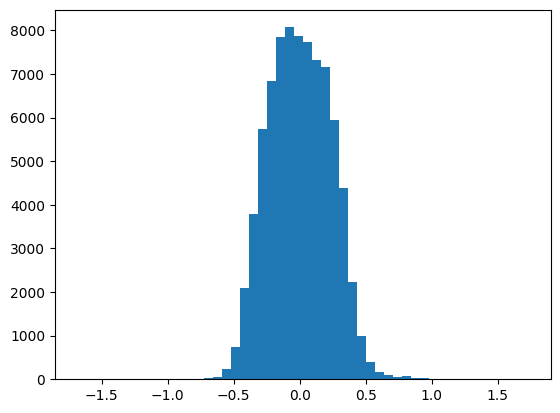

KS test p-value on training residuals: 0.000
AD test on training residuals: 144.610, critical values: [0.576 0.656 0.787 0.918 1.092], significance levels: [15.  10.   5.   2.5  1. ]
*** Test set
Test RMSE: 0.2337, MAE: 0.1911, MAPE: 0.5285
Mean model: RMSE: 0.3258, MAE: 0.2861, MAPE: 0.6490


In [8]:
# Simple LM, all IVs
metric = "post_saturation_n_craters_in_study_region_percentile"

exclude = {}
features = [x for x in ivs if x not in exclude]

xtr = train_df.reset_index().copy()
xte = test_df.reset_index().copy()

X_train = xtr[features]
X_test = xte[features]

y_train = xtr[metric]
y_test = xte[metric]

min_max_scaler = sklearn.preprocessing.MinMaxScaler()
X_train = min_max_scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns=min_max_scaler.get_feature_names_out())

poly_transform = sklearn.preprocessing.PolynomialFeatures(degree=1, include_bias=False)
X_train = poly_transform.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns=poly_transform.get_feature_names_out())

X_test = pd.DataFrame(min_max_scaler.transform(X_test), columns=min_max_scaler.get_feature_names_out())
X_test = poly_transform.transform(X_test)
X_test = pd.DataFrame(X_test, columns=poly_transform.get_feature_names_out())

model = fit_and_report_statsmodels_model(lambda y, x: sm.OLS(y, x),
                                         sm.add_constant(X_train),
                                         y_train,
                                         sm.add_constant(X_test),
                                         y_test,
                                         "LM No Interactions",
                                         transform=lambda x: x,
                                         inverse_transform=lambda x: x)

                                             OLS Regression Results                                             
Dep. Variable:     post_saturation_n_craters_in_study_region_percentile   R-squared:                       0.455
Model:                                                              OLS   Adj. R-squared:                  0.455
Method:                                                   Least Squares   F-statistic:                     4179.
Date:                                                  Sat, 23 Sep 2023   Prob (F-statistic):               0.00
Time:                                                          13:04:40   Log-Likelihood:                 261.62
No. Observations:                                                 80000   AIC:                            -489.2
Df Residuals:                                                     79983   BIC:                            -331.3
Df Model:                                                            16                         

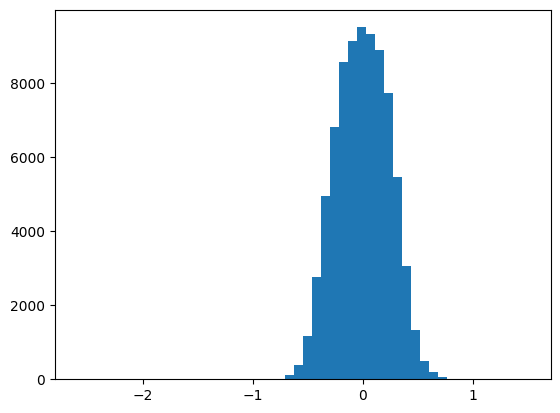

KS test p-value on training residuals: 0.000
AD test on training residuals: 96.553, critical values: [0.576 0.656 0.787 0.918 1.092], significance levels: [15.  10.   5.   2.5  1. ]
*** Test set
Test RMSE: 0.2454, MAE: 0.1957, MAPE: 0.7457
Mean model: RMSE: 0.3258, MAE: 0.2861, MAPE: 0.6490


In [36]:
# Simple LM, all IVs

metric = "post_saturation_n_craters_in_study_region_percentile"

exclude = {
    "center_to_center_nearest_neighbor_distance_max",
    "log_z",
    "log_za",
    "center_to_center_nearest_neighbor_distance_mean", # p value
    "log_center_to_center_nearest_neighbor_distance_min", # effect size
    "z", # effect size
    "log_center_to_center_nearest_neighbor_distance_max", # p value
    "log_center_to_center_nearest_neighbor_distance_max", # p value
    "log_center_to_center_nearest_neighbor_distance_max", # p value
    "areal_density",
    "areal_density_overlap_2",
    "areal_density_overlap_3",
}
features = [x for x in measured_ivs if x not in exclude] + [f"log_{x}" for x in measured_ivs if f"log_{x}" not in exclude]

xtr = train_df.reset_index().copy()
xte = test_df.reset_index().copy()

X_train = xtr[features]
X_test = xte[features]

y_train = xtr[metric]
y_test = xte[metric]

min_max_scaler = sklearn.preprocessing.MinMaxScaler()
X_train = min_max_scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns=min_max_scaler.get_feature_names_out())

poly_transform = sklearn.preprocessing.PolynomialFeatures(degree=1, include_bias=False)
X_train = poly_transform.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns=poly_transform.get_feature_names_out())

X_test = pd.DataFrame(min_max_scaler.transform(X_test), columns=min_max_scaler.get_feature_names_out())
X_test = poly_transform.transform(X_test)
X_test = pd.DataFrame(X_test, columns=poly_transform.get_feature_names_out())

model = fit_and_report_statsmodels_model(lambda y, x: sm.OLS(y, x),
                                         sm.add_constant(X_train),
                                         y_train,
                                         sm.add_constant(X_test),
                                         y_test,
                                         "LM No Interactions",
                                         transform=lambda x: x,
                                         inverse_transform=lambda x: x)

                                  Generalized Linear Model Regression Results                                   
Dep. Variable:     post_saturation_n_craters_in_study_region_percentile   No. Observations:                70193
Model:                                                              GLM   Df Residuals:                    70181
Model Family:                                                  Binomial   Df Model:                           11
Link Function:                                                    Logit   Scale:                          1.0000
Method:                                                            IRLS   Log-Likelihood:                -31591.
Date:                                                  Sat, 23 Sep 2023   Deviance:                       17438.
Time:                                                          13:13:03   Pearson chi2:                 1.61e+04
No. Iterations:                                                       5   Pseudo R-squ. (CS):   

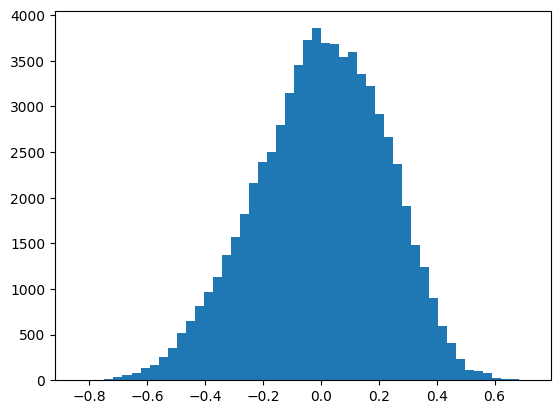

KS test p-value on training residuals: 0.000
AD test on training residuals: 83.313, critical values: [0.576 0.656 0.787 0.918 1.092], significance levels: [15.  10.   5.   2.5  1. ]
*** Test set
Test RMSE: 0.2187, MAE: 0.1754, MAPE: 0.4169
Mean model: RMSE: 0.3023, MAE: 0.2639, MAPE: 0.5253


In [54]:
# Simple model, all IVs, GLM w/binomial and logit link

metric = "post_saturation_n_craters_in_study_region_percentile"
exclude = {
    "log_z",
    "log_za",
    "z",
    "za",
}
# features = [x for x in measured_ivs if x not in exclude]
features = [f"log_{x}" for x in measured_ivs if f"log_{x}" not in exclude]

xtr = train_df[train_df[metric] > 0].reset_index().copy()
xte = test_df[test_df[metric] > 0].reset_index().copy()

X_train = xtr[features]
X_test = xte[features]

y_train = xtr[metric]
y_test = xte[metric]

min_max_scaler = sklearn.preprocessing.MinMaxScaler()
X_train = min_max_scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns=min_max_scaler.get_feature_names_out())

poly_transform = sklearn.preprocessing.PolynomialFeatures(degree=1, include_bias=False)
X_train = poly_transform.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns=poly_transform.get_feature_names_out())

X_test = pd.DataFrame(min_max_scaler.transform(X_test), columns=min_max_scaler.get_feature_names_out())
X_test = poly_transform.transform(X_test)
X_test = pd.DataFrame(X_test, columns=poly_transform.get_feature_names_out())

model = fit_and_report_statsmodels_model(lambda y, x: sm.GLM(y, x, family=sm.families.Binomial(link=sm.families.links.Logit())),
                                         sm.add_constant(X_train),
                                         y_train,
                                         sm.add_constant(X_test),
                                         y_test,
                                         "LM No Interactions",
                                         transform=lambda x: x,
                                         inverse_transform=lambda x: x)

In [ ]:
# Beta regression model

metric = "information_remaining"

# features = ["slope", "log_areal_density", "log_center_to_center_nearest_neighbor_distance_mean", "log_center_to_center_nearest_neighbor_distance_min", "log_rim_to_rim_nearest_neighbor_distance_mean", "log_n_craters_in_study_region"]
# features = ["log_center_to_center_nearest_neighbor_distance_stdev", "min_rim_percentage", "effective_radius_multiplier", "log_center_to_center_nearest_neighbor_distance_mean", "destruction", "log_areal_density", "log_areal_density_overlap_2", "log_areal_density_overlap_3", "log_center_to_center_nearest_neighbor_distance_max", "log_n_craters_in_study_region", "slope"]
# features = ["slope", "log_center_to_center_nearest_neighbor_distance_mean", "destruction", "areal_density", "areal_density_overlap_2", "areal_density_overlap_3"]

features = [
    "slope",
    # "effective_radius_multiplier",
    # "r_stat_multiplier",
    # "min_rim_percentage",
    "z",
    "za",
    "log_n_craters_in_study_region",
    "areal_density",
    "areal_density_overlap_2",
    # "areal_density_overlap_3",
    "log_center_to_center_nearest_neighbor_distance_mean",
    # "center_to_center_nearest_neighbor_distance_stdev",
    # "log_center_to_center_nearest_neighbor_distance_min",
    "log_center_to_center_nearest_neighbor_distance_max",
    "log_rim_to_rim_nearest_neighbor_distance_mean",
    # "log_rim_to_rim_nearest_neighbor_distance_stdev",
    # "log_rim_to_rim_nearest_neighbor_distance_max",
]

xtr = train_df.reset_index().copy()
xte = test_df.reset_index().copy()

xtr = xtr[xtr[metric] < 1.0].reset_index().copy()
xte = xte[xte[metric] < 1.0].reset_index().copy()

xtr = add_destruction(xtr)
xte = add_destruction(xte)

X_train = xtr[features]
X_test = xte[features]

y_train = xtr[metric]
y_test = xte[metric]

min_max_scaler = sklearn.preprocessing.MinMaxScaler()
X_train = min_max_scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns=min_max_scaler.get_feature_names_out())

poly_transform = sklearn.preprocessing.PolynomialFeatures(degree=1, include_bias=False)
X_train = poly_transform.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns=poly_transform.get_feature_names_out())

X_test = pd.DataFrame(min_max_scaler.transform(X_test), columns=min_max_scaler.get_feature_names_out())
X_test = poly_transform.transform(X_test)
X_test = pd.DataFrame(X_test, columns=poly_transform.get_feature_names_out())

model = fit_and_report_statsmodels_model(lambda y, x: BetaModel(y, x),
                                         sm.add_constant(X_train),
                                         y_train,
                                         sm.add_constant(X_test),
                                         y_test,
                                         "LM No Interactions",
                                         transform=lambda x: x,
                                         inverse_transform=lambda x: x)

In [ ]:
# Model for when information remaining is high

features = ["slope", "log_areal_density", "log_center_to_center_nearest_neighbor_distance_mean", "log_center_to_center_nearest_neighbor_distance_min", "log_rim_to_rim_nearest_neighbor_distance_mean", "log_n_craters_in_study_region"]

xtr = train_df[train_df.information_remaining > 0.6].reset_index().copy()
xte = test_df[test_df.information_remaining > 0.6].reset_index().copy()

X_train = xtr[features]
X_test = xte[features]

y_train = xtr[metric]
y_test = xte[metric]

min_max_scaler = sklearn.preprocessing.MinMaxScaler()
X_train = min_max_scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns=min_max_scaler.get_feature_names_out())

poly_transform = sklearn.preprocessing.PolynomialFeatures(degree=1, include_bias=False)
X_train = poly_transform.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns=poly_transform.get_feature_names_out())

X_test = pd.DataFrame(min_max_scaler.transform(X_test), columns=min_max_scaler.get_feature_names_out())
X_test = poly_transform.transform(X_test)
X_test = pd.DataFrame(X_test, columns=poly_transform.get_feature_names_out())

model = fit_and_report_statsmodels_model(lambda y, x: sm.OLS(y, x),
                                         X_train,
                                         y_train,
                                         X_test,
                                         y_test,
                                         "LM No Interactions",
                                         transform=lambda x: np.log(x),
                                         inverse_transform=lambda x: np.exp(x))

In [ ]:
# Model for when information remaining is low

features = ["slope", "log_areal_density", "log_center_to_center_nearest_neighbor_distance_mean", "log_center_to_center_nearest_neighbor_distance_min", "log_rim_to_rim_nearest_neighbor_distance_mean", "log_n_craters_in_study_region"]

xtr = train_df[train_df.information_remaining < 0.4].reset_index().copy()
xte = test_df[test_df.information_remaining < 0.4].reset_index().copy()

X_train = xtr[features]
X_test = xte[features]

y_train = xtr[metric]
y_test = xte[metric]

min_max_scaler = sklearn.preprocessing.MinMaxScaler()
X_train = min_max_scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns=min_max_scaler.get_feature_names_out())

poly_transform = sklearn.preprocessing.PolynomialFeatures(degree=1, include_bias=False)
X_train = poly_transform.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns=poly_transform.get_feature_names_out())

X_test = pd.DataFrame(min_max_scaler.transform(X_test), columns=min_max_scaler.get_feature_names_out())
X_test = poly_transform.transform(X_test)
X_test = pd.DataFrame(X_test, columns=poly_transform.get_feature_names_out())

model = fit_and_report_statsmodels_model(lambda y, x: sm.OLS(y, x),
                                         X_train,
                                         y_train,
                                         X_test,
                                         y_test,
                                         "LM No Interactions",
                                         transform=lambda x: np.log(x),
                                         inverse_transform=lambda x: np.exp(x))

In [ ]:
features = ivs #["za", "areal_density", "n_craters_in_study_region"]

X_train = train_df[features]
X_test = test_df[features]

y_train = train_df[metric]
y_test = test_df[metric]

min_max_scaler = sklearn.preprocessing.MinMaxScaler()
X_train = min_max_scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns=min_max_scaler.get_feature_names_out())

poly_transform = sklearn.preprocessing.PolynomialFeatures(degree=2, include_bias=False)
X_train = poly_transform.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns=poly_transform.get_feature_names_out())

X_test = pd.DataFrame(min_max_scaler.transform(X_test), columns=min_max_scaler.get_feature_names_out())
X_test = poly_transform.transform(X_test)
X_test = pd.DataFrame(X_test, columns=poly_transform.get_feature_names_out())

model = fit_and_report_statsmodels_model(lambda y, x: sm.OLS(y, x),
                                         sm.add_constant(X_train),
                                         y_train,
                                         sm.add_constant(X_test),
                                         y_test,
                                         "LM No Interactions",
                                         transform=lambda x: x,
                                         inverse_transform=lambda x: x)

In [ ]:
tr = train_df[train_df[metric] < .99]
te = test_df[test_df[metric] < .99]

X_train = tr[ivs]
X_test = te[ivs]

y_train = tr[metric]
y_test = te[metric]

model = fit_and_report_statsmodels_model(lambda y, x: sm.OLS(y, x),
                                         sm.add_constant(X_train),
                                         y_train,
                                         sm.add_constant(X_test),
                                         y_test,
                                         "LM No Interactions",
                                         transform=sm.families.links.Logit(),
                                         inverse_transform=sm.families.links.Logit().inverse)

In [ ]:
tr = train_df[train_df[metric] < .99]
te = test_df[test_df[metric] < .99]

X_train = tr[ivs]
X_test = te[ivs]

y_train = tr[metric]
y_test = te[metric]

model = fit_and_report_statsmodels_model(lambda y, x: sm.GLM(y, x, family=sm.families.Binomial(link=sm.families.links.Logit())),
                                         sm.add_constant(X_train),
                                         y_train,
                                         sm.add_constant(X_test),
                                         y_test,
                                         "LM No Interactions",
                                         transform=lambda x: x,
                                         inverse_transform=lambda x: x)

### With Interactions

In [ ]:
exclude = {}

features = [x for x in ivs if x not in exclude]

X_train = train_df[features]
X_tests = [x[features] for x in test_dfs]

y_train = train_df[metric]
y_tests = [x[metric] for x in test_dfs]

min_max_scaler = sklearn.preprocessing.MinMaxScaler()
X_train = min_max_scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns=min_max_scaler.get_feature_names_out())

poly_transform = sklearn.preprocessing.PolynomialFeatures(degree=2, include_bias=False)
X_train = poly_transform.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns=poly_transform.get_feature_names_out())

X_tests = [pd.DataFrame(min_max_scaler.transform(x), columns=min_max_scaler.get_feature_names_out()) for x in X_tests]
X_tests = [poly_transform.transform(x) for x in X_tests]
X_tests = [pd.DataFrame(x, columns=poly_transform.get_feature_names_out()) for x in X_tests]

model = fit_and_report_statsmodels_model(lambda y, x: sm.GLM(y, x, family=sm.families.Binomial(link=sm.families.links.Logit())),
                                         sm.add_constant(X_train),
                                         y_train,
                                         [sm.add_constant(x) for x in X_tests],
                                         y_tests,
                                         "LM With Interactions",
                                         transform=lambda x: x,
                                         inverse_transform=lambda x: x)

#### Removing Insignificant Variables

In [ ]:
add_const = True

exclude = {
    "r_stat_multiplier za", # p-value
    "r_stat_multiplier n_craters_in_study_region", # p-value
    "r_stat_multiplier areal_density", # p-value
    "slope za", # p-value
    "", # p-value
    "", # p-value
    "", # p-value
    "", # p-value
    "", # p-value
}

X_train = train_df[ivs]
X_tests = [x[ivs] for x in test_dfs]

y_train = train_df[metric]
y_tests = [x[metric] for x in test_dfs]

min_max_scaler = sklearn.preprocessing.MinMaxScaler()
X_train = min_max_scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns=min_max_scaler.get_feature_names_out())

poly_transform = sklearn.preprocessing.PolynomialFeatures(degree=2, include_bias=False)
X_train = poly_transform.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns=poly_transform.get_feature_names_out())
X_train = X_train[[x for x in X_train.columns if x not in exclude]]

X_tests = [pd.DataFrame(min_max_scaler.transform(x), columns=min_max_scaler.get_feature_names_out()) for x in X_tests]
X_tests = [poly_transform.transform(x) for x in X_tests]
X_tests = [pd.DataFrame(x, columns=poly_transform.get_feature_names_out()) for x in X_tests]
X_tests = [x[[y for y in x.columns if y not in exclude]] for x in X_tests]

model = fit_and_report_statsmodels_model(lambda y, x: sm.GLM(y, x, family=sm.families.Binomial(link=sm.families.links.Logit())),
                                         sm.add_constant(X_train),
                                         y_train,
                                         [sm.add_constant(x) for x in X_tests],
                                         y_tests,
                                         "GLM With Interactions",
                                         transform=lambda x: x,
                                         inverse_transform=lambda x: x)

In [ ]:
import statsmodels.api as sm
from sklearn.base import BaseEstimator, RegressorMixin

class SMWrapper(BaseEstimator, RegressorMixin):
    """ A universal sklearn-style wrapper for statsmodels regressors """
    def __init__(self, model_creator_func, fit_kwargs={}):
        self.model_creator_func = model_creator_func
        self.fit_kwargs = fit_kwargs
        
    def fit(self, X, y):
        self.model_ = self.model_creator_func(y, X)
        self.results_ = self.model_.fit(**self.fit_kwargs)
        return self
    
    def predict(self, X):
        return self.results_.predict(X)
    
    @property
    def coef_(self):
        return self.results_.params

In [ ]:
exclude = {}

X_train = train_df[ivs]
X_tests = [x[ivs] for x in test_dfs]

y_train = train_df[metric]
y_tests = [x[metric] for x in test_dfs]

min_max_scaler = sklearn.preprocessing.MinMaxScaler()
X_train = min_max_scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns=min_max_scaler.get_feature_names_out())

poly_transform = sklearn.preprocessing.PolynomialFeatures(degree=2, include_bias=False)
X_train = poly_transform.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns=poly_transform.get_feature_names_out())
X_train = X_train[[x for x in X_train.columns if x not in exclude]]

X_tests = [pd.DataFrame(min_max_scaler.transform(x), columns=min_max_scaler.get_feature_names_out()) for x in X_tests]
X_tests = [poly_transform.transform(x) for x in X_tests]
X_tests = [pd.DataFrame(x, columns=poly_transform.get_feature_names_out()) for x in X_tests]
X_tests = [x[[y for y in x.columns if y not in exclude]] for x in X_tests]

In [ ]:
min_features_to_select = 1 
model = SMWrapper(lambda y, x: sm.GLM(y, x, family=sm.families.Binomial(link=sm.families.links.Logit())))
cv = KFold(5)

rfecv = RFECV(
    estimator=model,
    step=1,
    cv=cv,
    scoring="neg_root_mean_squared_error",
    min_features_to_select=min_features_to_select,
    n_jobs=1
)
rfecv.fit(X_train, y_train)

In [ ]:
model = fit_and_report_statsmodels_model(lambda y, x: sm.GLM(y, x, family=sm.families.Binomial(link=sm.families.links.Logit())),
                                         sm.add_constant(X_train[rfecv.get_feature_names_out()]),
                                         y_train,
                                         [sm.add_constant(x[rfecv.get_feature_names_out()]) for x in X_tests],
                                         y_tests,
                                         "LM With RFE Features",
                                         transform=lambda x: x,
                                         inverse_transform=lambda x: x)

In [ ]:
# Checking effect sizes
max_coef = max([abs(x) for x, y in zip(model.params, model.params.index) if y != "const"])
sorted([(abs(x / max_coef), y) for x, y in zip(model.params, model.params.index)])

In [ ]:
# Checking highest p-value
model.pvalues.sort_values(ascending=False)

### Trying a Gaussian GLM with Log Link

In [ ]:
add_const = True

exclude = {
    "effective_radius_multiplier r_stat_multiplier", # effect size
    "r_stat_multiplier min_rim_percentage", # effect size
    "slope r_stat_multiplier", # effect size
    "r_stat_multiplier^2", # effect size
    "slope effective_radius_multiplier", # effect size
    "r_stat_multiplier", # effect size
    "min_rim_percentage^2", # effect size
    "", # effect size
    "", # effect size
    "", # effect size
}

X_train = train_df[ivs]
X_tests = [x[ivs] for x in test_dfs]

y_train = train_df[metric]
y_tests = [x[metric] for x in test_dfs]

min_max_scaler = sklearn.preprocessing.MinMaxScaler()
X_train = min_max_scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns=min_max_scaler.get_feature_names_out())

poly_transform = sklearn.preprocessing.PolynomialFeatures(degree=2, include_bias=False)
X_train = poly_transform.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns=poly_transform.get_feature_names_out())
X_train = X_train[[x for x in X_train.columns if x not in exclude]]

X_tests = [pd.DataFrame(min_max_scaler.transform(x), columns=min_max_scaler.get_feature_names_out()) for x in X_tests]
X_tests = [poly_transform.transform(x) for x in X_tests]
X_tests = [pd.DataFrame(x, columns=poly_transform.get_feature_names_out()) for x in X_tests]
X_tests = [x[[y for y in x.columns if y not in exclude]] for x in X_tests]

model = fit_and_report_statsmodels_model(lambda y, x: sm.OLS(y, x),
                                         sm.add_constant(X_train),
                                         y_train,
                                         [sm.add_constant(x) for x in X_tests],
                                         y_tests,
                                         "LM With Interactions",
                                         transform=sm.families.links.Logit(),
                                         inverse_transform=sm.families.links.Logit().inverse)

In [ ]:
# Checking effect sizes
max_coef = max([abs(x) for x, y in zip(model.params, model.params.index) if y != "const"])
sorted([(abs(x / max_coef), y) for x, y in zip(model.params, model.params.index)])

In [ ]:
# Checking highest p-value
model.pvalues.sort_values(ascending=False)

### Trying Poisson GLM with log link

In [ ]:
add_const = True

exclude = {
    "effective_radius_multiplier r_stat_multiplier", # effect size
    "r_stat_multiplier min_rim_percentage", # effect size
    "slope r_stat_multiplier", # effect size
    "r_stat_multiplier^2", # effect size
    "slope effective_radius_multiplier", # effect size
    "r_stat_multiplier", # effect size
    "min_rim_percentage^2", # effect size
    "", # effect size
    "", # effect size
    "", # effect size
}

X_train = train_df[ivs]
X_tests = [x[ivs] for x in test_dfs]

y_train = train_df[metric]
y_tests = [x[metric] for x in test_dfs]

min_max_scaler = sklearn.preprocessing.MinMaxScaler()
X_train = min_max_scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns=min_max_scaler.get_feature_names_out())

poly_transform = sklearn.preprocessing.PolynomialFeatures(degree=2, include_bias=False)
X_train = poly_transform.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns=poly_transform.get_feature_names_out())
X_train = X_train[[x for x in X_train.columns if x not in exclude]]

X_tests = [pd.DataFrame(min_max_scaler.transform(x), columns=min_max_scaler.get_feature_names_out()) for x in X_tests]
X_tests = [poly_transform.transform(x) for x in X_tests]
X_tests = [pd.DataFrame(x, columns=poly_transform.get_feature_names_out()) for x in X_tests]
X_tests = [x[[y for y in x.columns if y not in exclude]] for x in X_tests]

model = fit_and_report_statsmodels_glm_model(sm.families.Poisson(link=sm.families.links.Log()),
                                             sm.add_constant(X_train),
                                             y_train,
                                             [sm.add_constant(x) for x in X_tests],
                                             y_tests,
                                             "GLM With Interactions")

In [ ]:
# Checking effect sizes
max_coef = max([abs(x) for x, y in zip(model.params, model.params.index) if y != "const"])
sorted([(abs(x / max_coef), y) for x, y in zip(model.params, model.params.index)])

### Trying with degree=3

In [ ]:
exclude = {
    "slope r_stat_multiplier min_rim_percentage", # p-value
    "r_stat_multiplier^2 min_rim_percentage", # effect size
    "const", # effect size
    "effective_radius_multiplier r_stat_multiplier min_rim_percentage", # effect size
    "slope r_stat_multiplier^2", # effect size
    "slope^2 r_stat_multiplier", # effect size
    "slope effective_radius_multiplier r_stat_multiplier", # effect size
    "", # effect size
    "", # effect size
    "", # effect size
    "", # effect size
}

X_train = train_df[ivs]
X_tests = [x[ivs] for x in test_dfs]

y_train = train_df[metric]
y_tests = [x[metric] for x in test_dfs]

min_max_scaler = sklearn.preprocessing.MinMaxScaler()
X_train = min_max_scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns=min_max_scaler.get_feature_names_out())

poly_transform = sklearn.preprocessing.PolynomialFeatures(degree=3, include_bias=False)
X_train = poly_transform.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns=poly_transform.get_feature_names_out())
X_train = X_train[[x for x in X_train.columns if x not in exclude]]

X_tests = [pd.DataFrame(min_max_scaler.transform(x), columns=min_max_scaler.get_feature_names_out()) for x in X_tests]
X_tests = [poly_transform.transform(x) for x in X_tests]
X_tests = [pd.DataFrame(x, columns=poly_transform.get_feature_names_out()) for x in X_tests]
X_tests = [x[[y for y in x.columns if y not in exclude]] for x in X_tests]

model = fit_and_report_statsmodels_model(sm.OLS,
                                         X_train,
                                         y_train,
                                         X_tests,
                                         y_tests,
                                         "LM With Reduced Interactions",
                                         transform=lambda x: x,
                                         inverse_transform=lambda x: x)

In [ ]:
# Checking effect sizes
max_coef = max([abs(x) for x, y in zip(model.params, model.params.index) if y != "const"])
sorted([(abs(x / max_coef), y) for x, y in zip(model.params, model.params.index)])

In [ ]:
# Checking highest p-value
model.pvalues.sort_values(ascending=False)

### Plotting Prediction Intervals

In [ ]:
def read_simulation_parquet(path: Path, features: list[str], sample_cadence: int) -> pd.DataFrame:
    df = pd.read_parquet(path)
    df = df.iloc[[x * sample_cadence + 1 for x in range(df.shape[0] // sample_cadence)]].copy()
    df = fix_up_df(df)[features + ["simulation_id", "n_craters_added_in_study_region", metric]]
    return df

def score_model(model,
                df: pd.DataFrame,
                alphas: list[float],
                features: list[str],
                metric: str,
                transform,
                inverse_transform,
                add_constant: bool) -> pd.DataFrame:
    X = df[features]
    X = min_max_scaler.transform(X)
    X = pd.DataFrame(X, columns=min_max_scaler.get_feature_names_out())
    
    X = poly_transform.transform(X)
    X = pd.DataFrame(X, columns=poly_transform.get_feature_names_out())

    pred_df = df.reset_index(drop=True).copy()
    pred_df = pd.concat([pred_df, X[[x for x in poly_transform.get_feature_names_out() if x not in df.columns]].copy()], axis=1)
    # for feature_name in poly_transform.get_feature_names_out():
    #     pred_df[feature_name] = X[feature_name]
    
    X = X[poly_transform.get_feature_names_out()].copy()
    y = transform(df[metric])
    
    if add_constant:
        X = sm.add_constant(X, has_constant="add")
    pred_df["actual"] = list(df[metric])
    pred_df["n_craters"] = list(df.index)
    
    is_glm = type(model) == statsmodels.genmod.generalized_linear_model.GLMResultsWrapper
    
    if is_glm:
        link = model.family.link
        predictions = inverse_transform(model.predict(X))
        resid = link(pred_df.actual) - link(predictions)
        var_pred_mean = (X * np.dot(model.cov_params(), X.T).T).sum(1)
        var_resid = resid.var()
        sigma = np.sqrt(var_pred_mean + var_resid)
        n = pred_df.shape[0]
    else:
        predictions = model.get_prediction(X)
    
    for alpha in alphas:
        if is_glm:
            pred_df[f"alpha_{alpha:.2f}"] = link.inverse(link(predictions) - sigma * stats.distributions.t.ppf(1 - alpha, n - 2) * np.sqrt(1 + 1 / n))
        else:
            ci_lower = predictions.conf_int(obs=True, alpha=alpha*2)[:,0]
            pred_df[f"alpha_{alpha:.2f}"] = inverse_transform(ci_lower)
            pred_df["predicted"] = inverse_transform(predictions.predicted)
    
    return pred_df


def score_model_from_parquet_file(model,
                                  parquet_path: Path,
                                  sample_cadence: int,
                                  alphas: list[float],
                                  features: list[str],
                                  metric: str,
                                  transform,
                                  inverse_transform,
                                  add_constant: bool) -> pd.DataFrame:
    df = read_simulation_parquet(parquet_path, features, sample_cadence)
    return score_model(model, df, alphas, features, metric, transform, inverse_transform, add_constant)
        

def plot_sim_ci(model,
                parquet_path: Path,
                sample_cadence: int,
                alphas: list[float],
                features: list[str],
                metric: str,
                transform,
                inverse_transform,
                add_constant):
    pred_df = score_model_from_parquet_file(model, parquet_path, sample_cadence, alphas, features, metric, transform, inverse_transform, add_constant)
    
    # Show params
    print(f"Simulation parameters: {pred_df[features].iloc[0]}")

    
    fig = go.Figure()
    fig.add_scatter(x=pred_df["n_craters"],
                    y=pred_df["actual"],
                    mode="lines",
                    name="Actual")
    
    for alpha in alphas:
        fig.add_scatter(x=pred_df["n_craters"],
                        y=pred_df[f"alpha_{alpha:.2f}"],
                        mode="lines",
                        name=f"Pred {int(alpha*100)} Percentile")

    fig.update_layout(
        xaxis_title="$N_G$",
        yaxis_title=metric
    )

    fig.show()


def plot_sim(model,
             parquet_path: Path,
             sample_cadence: int,
             alphas: list[float],
             features: List[str],
             metric: str,
             transform,
             inverse_transform,
             add_constant):
    pred_df = score_model_from_parquet_file(model, parquet_path, sample_cadence, alphas, features, metric, transform, inverse_transform, add_constant)
    
    # Show params
    print(f"Simulation parameters: {pred_df[features].iloc[0]}")
    
    fig = go.Figure()

    fig.add_scatter(x=pred_df["n_craters"],
                    y=pred_df["actual"],
                    mode="lines",
                    name="Actual")
    
    fig.add_scatter(x=pred_df["n_craters"],
                    y=pred_df["predicted"],
                    mode="lines",
                    name=f"Predicted")

    fig.update_layout(
        xaxis_title="$N_G$",
        yaxis_title=metric
    )

    fig.show()
    
    
def report_alphas(model,
                  df: pd.DataFrame,
                  alphas: list[float],
                  features: list[str],
                  metric: str,
                  transform,
                  inverse_transform,
                  add_constant: bool):
    pred_df = score_model(model, df, alphas, features, metric, transform, inverse_transform, add_constant)
    
    # Report alphas for only the last third
    pred_df = pred_df.iloc[pred_df.shape[0] // 3 * 2:]
    
    for alpha in alphas:
        percent_below = (pred_df.actual < pred_df[f"alpha_{alpha:.2f}"]).mean() * 100
        print(f"Alpha = {alpha:.2f}, % below: {percent_below:.2f}")
        

def report_alphas_for_parquets(model,
                               parquet_paths: list[Path],
                               sample_cadence: int,
                               alphas: list[float],
                               features: list[str],
                               metric: str,
                               transform,
                               inverse_transform,
                               add_constant: bool):
    n_below = defaultdict(lambda: 0)
    n = defaultdict(lambda: 0)
    for path in parquet_paths:
        pred_df = score_model_from_parquet_file(model, path, sample_cadence, alphas, features, metric, transform, inverse_transform, add_constant)
        
        for alpha in alphas:
            n_below[alpha] += (pred_df.actual < pred_df[f"alpha_{alpha:.2f}"]).sum()
            n[alpha] += pred_df.shape[0]
    
    for alpha in alphas:
        percent_below = n_below[alpha] / n[alpha] * 100
        print(f"Alpha = {alpha:.2f}, % below: {percent_below:.2f}")

In [ ]:
# def read_simulation_parquet(path: Path, sample_cadence: int) -> pd.DataFrame:
#     df = pd.read_parquet(path)
#     df = df.iloc[[x * sample_cadence for x in range(df.shape[0] // sample_cadence)]].copy()
#     df = fix_up_df(df)[ivs + ["simulation_id", "n_craters_added_in_study_region", metric]]
#     return df


# def score_model(model,
#                 df: pd.DataFrame,
#                 feature_names: List[str],
#                 metric: str,
#                 transform,
#                 inverse_transform,
#                 add_constant: bool) -> pd.DataFrame:
#     X = df[ivs]
#     X = min_max_scaler.transform(X)
#     X = pd.DataFrame(X, columns=min_max_scaler.get_feature_names_out())
    
#     X = poly_transform.transform(X)
#     X = pd.DataFrame(X, columns=poly_transform.get_feature_names_out())

#     pred_df = df.reset_index(drop=True).copy()
#     for feature_name in poly_transform.get_feature_names_out():
#         pred_df[feature_name] = X[feature_name]
    
#     X = X[feature_names].copy()
#     y = transform(df[metric])
    
#     if add_constant:
#         X = sm.add_constant(X, has_constant="add")
#     pred_df["actual"] = list(df[metric])
#     pred_df["n_craters"] = list(df.index)
#     pred_df["predicted"] = list(inverse_transform(model.predict(X)))
    
#     return pred_df


# def score_model_from_parquet_file(model,
#                                   parquet_path: Path,
#                                   sample_cadence: int,
#                                   feature_names: List[str],
#                                   metric: str,
#                                   transform,
#                                   inverse_transform,
#                                   add_constant: bool) -> pd.DataFrame:
#     df = read_simulation_parquet(parquet_path, sample_cadence)
#     return score_model(model, df, feature_names, metric, transform, inverse_transform, add_constant)


# def plot_sim_ci(model,
#                 parquet_path: Path,
#                 sample_cadence: int,
#                 feature_names: List[str],
#                 metric: str,
#                 transform,
#                 inverse_transform,
#                 add_constant):
#     pred_df = score_model_from_parquet_file(model, parquet_path, sample_cadence, feature_names, metric, transform, inverse_transform, add_constant)
    
#     # Show params
#     print(f"Simulation parameters: {pred_df[ivs].iloc[0]}")

#     ns_max = 100000
#     plt.plot(pred_df.n_craters_added_in_study_region.iloc[:ns_max],
#              pred_df[metric].iloc[:ns_max])
#     plt.xlabel("$N_G$")
#     plt.ylabel("$Predicted$")
#     plt.show()
    
#     fig = go.Figure()

#     fig.add_scatter(x=pred_df["n_craters"],
#                     y=pred_df["actual"],
#                     mode="lines",
#                     name="Actual")
    
#     fig.add_scatter(x=pred_df["n_craters"],
#                     y=pred_df["predicted"],
#                     mode="lines",
#                     name=f"Predicted")

#     fig.update_layout(
#         xaxis_title="$N_G$",
#         yaxis_title=metric
#     )

#     fig.show()
    

# def plot_sim(model,
#              parquet_path: Path,
#              sample_cadence: int,
#              feature_names: List[str],
#              metric: str,
#              transform,
#              inverse_transform,
#              add_constant):
#     pred_df = score_model_from_parquet_file(model, parquet_path, sample_cadence, feature_names, metric, transform, inverse_transform, add_constant)
    
#     # Show params
#     print(f"Simulation parameters: {pred_df[ivs].iloc[0]}")
    
#     fig = go.Figure()

#     fig.add_scatter(x=pred_df["n_craters"],
#                     y=pred_df["actual"],
#                     mode="lines",
#                     name="Actual")
    
#     fig.add_scatter(x=pred_df["n_craters"],
#                     y=pred_df["predicted"],
#                     mode="lines",
#                     name=f"Predicted")

#     fig.update_layout(
#         xaxis_title="$N_G$",
#         yaxis_title=metric
#     )

#     fig.show()

In [ ]:
# Load up a subset of the test DFs
np.random.seed(123)

sample_cadence = 500
alphas = [0.01, 0.05, 0.25, 0.5]
simulation_paths = list(Path(base_path).glob("simulation_*.parquet"))

In [ ]:
exclude = {
}

# features = [
#     "slope",
#     "effective_radius_multiplier",
#     "r_stat_multiplier",
#     "min_rim_percentage",
#     "z",
#     "za",
#     "areal_density",
#     # "areal_density_overlap_2",
#     "areal_density_overlap_3",
#     "center_to_center_nearest_neighbor_distance_mean",
#     # "center_to_center_nearest_neighbor_distance_stdev",
#     # "center_to_center_nearest_neighbor_distance_min",
#     # "center_to_center_nearest_neighbor_distance_max",
#     "rim_to_rim_nearest_neighbor_distance_mean",
#     # "rim_to_rim_nearest_neighbor_distance_stdev",
#     "rim_to_rim_nearest_neighbor_distance_max",
#     "percent_rim_to_rim_nearest_neighbors_zero"
# ]
features = ivs

# tr = train_df[train_df[metric] < .99].reset_index()
# te = test_df[test_df[metric] < .99].reset_index()

tr = train_df.reset_index()
te = test_df.reset_index()

X_train = tr[features]
X_test = te[features]

y_train = tr[metric]
y_test = te[metric]

min_max_scaler = sklearn.preprocessing.MinMaxScaler()
X_train = min_max_scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns=min_max_scaler.get_feature_names_out())

poly_transform = sklearn.preprocessing.PolynomialFeatures(degree=1, include_bias=False)
X_train = poly_transform.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns=poly_transform.get_feature_names_out())

X_test = pd.DataFrame(min_max_scaler.transform(X_test), columns=min_max_scaler.get_feature_names_out())
X_test = poly_transform.transform(X_test)
X_test = pd.DataFrame(X_test, columns=poly_transform.get_feature_names_out())

# model = fit_and_report_statsmodels_model(lambda y, x: sm.GLM(y, x, family=sm.families.Binomial(link=sm.families.links.Logit())),
#                                          sm.add_constant(X_train),
#                                          y_train,
#                                          [sm.add_constant(x) for x in X_tests],
#                                          y_tests,
#                                          "LM With Interactions",
#                                          transform=lambda x: x,
#                                          inverse_transform=lambda x: x)

# model = fit_and_report_statsmodels_model(lambda y, x: sm.OLS(y, x),
#                                          sm.add_constant(X_train),
#                                          y_train,
#                                          [sm.add_constant(x) for x in X_tests],
#                                          y_tests,
#                                          "LM No Interactions",
#                                          transform=sm.families.links.Logit(),
#                                          inverse_transform=sm.families.links.Logit().inverse)

# model = fit_and_report_statsmodels_model(lambda y, x: BetaModel(y, x),
#                                          (X_train),
#                                          y_train,
#                                          (X_test),
#                                          y_test,
#                                          "LM No Interactions",
#                                          transform=lambda x: x,
#                                          inverse_transform=lambda x: x)

transform = lambda x: x
inverse_transform = lambda x: x

model = fit_and_report_statsmodels_model(lambda y, x: sm.OLS(y, x),
                                         sm.add_constant(X_train),
                                         y_train,
                                         sm.add_constant(X_test),
                                         y_test,
                                         "LM No Interactions",
                                         transform=transform,
                                         inverse_transform=inverse_transform)


# transform = sm.families.links.Logit()
# inverse_transform = sm.families.links.Logit().inverse

# model = fit_and_report_statsmodels_model(lambda y, x: sm.OLS(y, x),
#                                          sm.add_constant(X_train),
#                                          y_train,
#                                          sm.add_constant(X_test),
#                                          y_test,
#                                          "LM No Interactions",
#                                          transform=transform,
#                                          inverse_transform=inverse_transform)

In [ ]:
report_alphas(model, train_df, alphas, features, metric, transform=transform, inverse_transform=inverse_transform, add_constant=True)

In [ ]:
report_alphas(model, test_df, alphas, features, metric, transform=transform, inverse_transform=inverse_transform, add_constant=True)

In [ ]:
report_alphas_for_parquets(model, simulation_paths[:100], sample_cadence, alphas, features, metric, transform=transform, inverse_transform=inverse_transform, add_constant=True)

In [ ]:
# Visualize CIs for a few in-CCD simulations
for x in range(10, 15):
    print(x)
    plot_sim(model, simulation_paths[x], 100, alphas, features, metric, transform=transform, inverse_transform=inverse_transform, add_constant=True)

In [ ]:
# Visualize CIs for a few simulations
for x in range(10, 15):
    print(x)
    plot_sim_ci(model, simulation_paths[x], sample_cadence, alphas, features, metric, transform=transform, inverse_transform=inverse_transform, add_constant=True)